In [1]:
import os
import pickle
import numpy as np

def load_cifar10_batch(filename):
    with open(filename, 'rb') as f:
        batch = pickle.load(f, encoding='bytes')
        images = batch[b'data'].reshape(-1, 3, 32, 32)  
        labels = np.array(batch[b'labels'])
        return images, labels

def load_cifar10_dataset(data_dir):
    train_images = []
    train_labels = []
    for i in range(1, 6):
        batch_file = os.path.join(data_dir, f'data_batch_{i}')
        imgs, lbls = load_cifar10_batch(batch_file)
        train_images.append(imgs)
        train_labels.append(lbls)
    train_images = np.concatenate(train_images, axis=0)
    train_labels = np.concatenate(train_labels, axis=0)

    # 加载测试集
    test_file = os.path.join(data_dir, 'test_batch')
    test_images, test_labels = load_cifar10_batch(test_file)

    return train_images, train_labels, test_images, test_labels

# 调用加载函数
data_dir = '../cifar10/cifar-10-batches-py'
train_images, train_labels, test_images, test_labels = load_cifar10_dataset(data_dir)

In [2]:
print(train_images.shape, train_labels.shape)

(50000, 3, 32, 32) (50000,)


In [3]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image

class CIFAR10Dataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        img = self.images[idx]
        img = np.transpose(img, (1, 2, 0))  
        img = Image.fromarray(img)        
        label = self.labels[idx]
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(label, dtype=torch.long)

In [4]:
train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [5]:
# 创建 Dataset
train_dataset = CIFAR10Dataset(train_images[:45000], train_labels[:45000], transform=train_transform)
dev_dataset=CIFAR10Dataset(train_images[45000:], train_labels[45000:], transform=test_transform)
test_dataset = CIFAR10Dataset(test_images, test_labels, transform=test_transform)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, num_workers=0)
dev_loader = DataLoader(dev_dataset, batch_size=128, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=0)


In [6]:
# 获取一个 batch
images, labels = next(iter(train_loader))

# 查看最小值和最大值
print("Min value:", images.min().item())
print("Max value:", images.max().item())

Min value: -1.0
Max value: 1.0


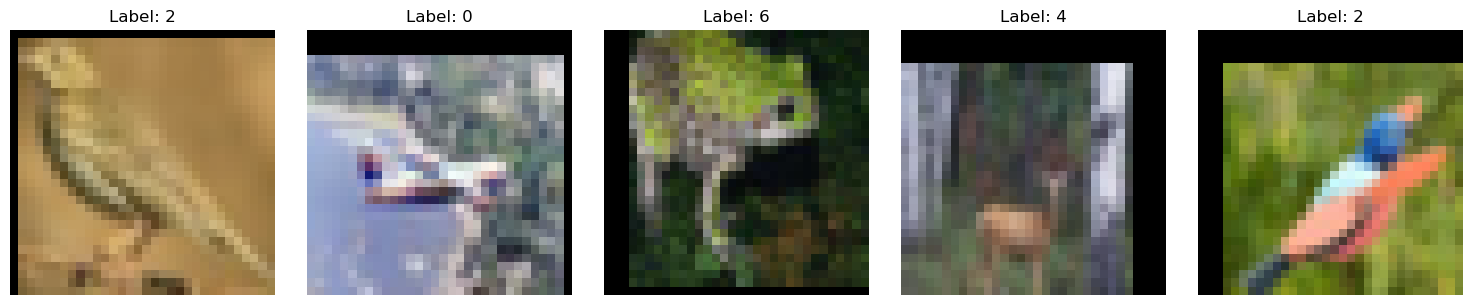

In [7]:
import matplotlib.pyplot as plt
import torchvision

# 如果你使用了 Normalize，需要定义逆变换
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]
inv_normalize = torchvision.transforms.Normalize(
    mean=[-m/s for m, s in zip(mean, std)],
    std=[1/s for s in std]
)

# 获取一个 batch
images, labels = next(iter(train_loader))

# 只看前5张
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    img = inv_normalize(images[i]).clamp(0, 1)  # 逆归一化并裁剪
    img = img.permute(1, 2, 0).cpu().numpy()    # CHW -> HWC
    axs[i].imshow(img)
    axs[i].set_title(f"Label: {labels[i].item()}")
    axs[i].axis('off')

plt.tight_layout()
plt.show()


In [8]:
print(len(train_dataset), len(dev_dataset))

45000 5000


In [9]:
import torch.nn as nn
import torch
import torch.nn.functional as F

class Residual(nn.Module):  #@save
    def __init__(self, input_channels, num_channels,
                 use_1x1conv=False, strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels,
                               kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels,
                               kernel_size=3, padding=1)
        if use_1x1conv:
            self.conv3 = nn.Conv2d(input_channels, num_channels,
                                   kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)

    def forward(self, X):
        Y = F.relu(self.bn1(self.conv1(X)))
        Y = self.bn2(self.conv2(Y))
        if self.conv3:
            X = self.conv3(X)
        Y += X
        return F.relu(Y)

In [10]:
class ResNetSmall(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),  # 输出: [B,64,32,32]
            nn.BatchNorm2d(64),
            nn.ReLU(),

            # Stage 1
            Residual(64, 64),
            Residual(64, 64),

            # Stage 2
            Residual(64, 128, use_1x1conv=True, strides=2),  
            Residual(128, 128),

            # Stage 3
            Residual(128, 256, use_1x1conv=True, strides=2), 
            Residual(256, 256),

            nn.AdaptiveAvgPool2d((1, 1)),  
            nn.Flatten(),                 
            nn.Linear(256, num_classes)   
        )

    def forward(self, x):
        return self.net(x)

In [11]:
import torch.optim as optim
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetSmall().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [12]:
print(device)

cuda


In [13]:
from tqdm import tqdm
train_losses, dev_losses = [], []
train_accuracies, dev_accuracies = [], []
best_acc = 0.0
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    total_loss, correct, total = 0, 0, 0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    for inputs, labels in pbar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_loss = total_loss / total
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # 验证阶段
    model.eval()
    dev_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for inputs, labels in dev_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            dev_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    dev_loss /= total
    dev_acc = correct / total
    dev_losses.append(dev_loss)
    dev_accuracies.append(dev_acc)

    print(f"Epoch {epoch+1} => Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {dev_loss:.4f}, Acc: {dev_acc:.4f}")

    if dev_acc > best_acc:
        best_acc = dev_acc
        torch.save(model.state_dict(), 'best_model.pth')

Epoch 1/100: 100%|██████████| 352/352 [00:50<00:00,  6.93it/s]


Epoch 1 => Train Loss: 1.4221, Acc: 0.4752 | Val Loss: 1.1924, Acc: 0.5734


Epoch 2/100: 100%|██████████| 352/352 [00:52<00:00,  6.73it/s]


Epoch 2 => Train Loss: 0.9516, Acc: 0.6631 | Val Loss: 1.0891, Acc: 0.6526


Epoch 3/100: 100%|██████████| 352/352 [00:52<00:00,  6.68it/s]


Epoch 3 => Train Loss: 0.7366, Acc: 0.7412 | Val Loss: 0.8063, Acc: 0.7280


Epoch 4/100: 100%|██████████| 352/352 [00:51<00:00,  6.87it/s]


Epoch 4 => Train Loss: 0.6070, Acc: 0.7901 | Val Loss: 0.5769, Acc: 0.8048


Epoch 5/100: 100%|██████████| 352/352 [00:49<00:00,  7.07it/s]


Epoch 5 => Train Loss: 0.5211, Acc: 0.8228 | Val Loss: 0.6532, Acc: 0.7846


Epoch 6/100: 100%|██████████| 352/352 [00:49<00:00,  7.09it/s]


Epoch 6 => Train Loss: 0.4643, Acc: 0.8411 | Val Loss: 0.5051, Acc: 0.8244


Epoch 7/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 7 => Train Loss: 0.4099, Acc: 0.8591 | Val Loss: 0.4734, Acc: 0.8438


Epoch 8/100: 100%|██████████| 352/352 [00:49<00:00,  7.05it/s]


Epoch 8 => Train Loss: 0.3719, Acc: 0.8720 | Val Loss: 0.5005, Acc: 0.8372


Epoch 9/100: 100%|██████████| 352/352 [00:50<00:00,  6.98it/s]


Epoch 9 => Train Loss: 0.3404, Acc: 0.8822 | Val Loss: 0.4172, Acc: 0.8642


Epoch 10/100: 100%|██████████| 352/352 [01:01<00:00,  5.71it/s]


Epoch 10 => Train Loss: 0.3144, Acc: 0.8914 | Val Loss: 0.4422, Acc: 0.8534


Epoch 11/100: 100%|██████████| 352/352 [00:52<00:00,  6.75it/s]


Epoch 11 => Train Loss: 0.2885, Acc: 0.8992 | Val Loss: 0.3945, Acc: 0.8676


Epoch 12/100: 100%|██████████| 352/352 [00:56<00:00,  6.28it/s]


Epoch 12 => Train Loss: 0.2688, Acc: 0.9060 | Val Loss: 0.3693, Acc: 0.8818


Epoch 13/100: 100%|██████████| 352/352 [00:59<00:00,  5.91it/s]


Epoch 13 => Train Loss: 0.2443, Acc: 0.9140 | Val Loss: 0.3997, Acc: 0.8706


Epoch 14/100: 100%|██████████| 352/352 [00:53<00:00,  6.61it/s]


Epoch 14 => Train Loss: 0.2297, Acc: 0.9197 | Val Loss: 0.4049, Acc: 0.8782


Epoch 15/100: 100%|██████████| 352/352 [00:48<00:00,  7.25it/s]


Epoch 15 => Train Loss: 0.2080, Acc: 0.9275 | Val Loss: 0.3893, Acc: 0.8822


Epoch 16/100: 100%|██████████| 352/352 [00:48<00:00,  7.20it/s]


Epoch 16 => Train Loss: 0.1932, Acc: 0.9314 | Val Loss: 0.4122, Acc: 0.8772


Epoch 17/100: 100%|██████████| 352/352 [00:48<00:00,  7.25it/s]


Epoch 17 => Train Loss: 0.1849, Acc: 0.9362 | Val Loss: 0.4147, Acc: 0.8798


Epoch 18/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 18 => Train Loss: 0.1690, Acc: 0.9403 | Val Loss: 0.3621, Acc: 0.8852


Epoch 19/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 19 => Train Loss: 0.1637, Acc: 0.9428 | Val Loss: 0.3570, Acc: 0.8944


Epoch 20/100: 100%|██████████| 352/352 [00:48<00:00,  7.23it/s]


Epoch 20 => Train Loss: 0.1533, Acc: 0.9448 | Val Loss: 0.3149, Acc: 0.9016


Epoch 21/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 21 => Train Loss: 0.1431, Acc: 0.9485 | Val Loss: 0.3334, Acc: 0.9026


Epoch 22/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 22 => Train Loss: 0.1292, Acc: 0.9538 | Val Loss: 0.3496, Acc: 0.8994


Epoch 23/100: 100%|██████████| 352/352 [00:47<00:00,  7.34it/s]


Epoch 23 => Train Loss: 0.1225, Acc: 0.9576 | Val Loss: 0.3568, Acc: 0.8994


Epoch 24/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 24 => Train Loss: 0.1173, Acc: 0.9580 | Val Loss: 0.3536, Acc: 0.9012


Epoch 25/100: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s]


Epoch 25 => Train Loss: 0.1081, Acc: 0.9617 | Val Loss: 0.3662, Acc: 0.9058


Epoch 26/100: 100%|██████████| 352/352 [00:48<00:00,  7.25it/s]


Epoch 26 => Train Loss: 0.1022, Acc: 0.9641 | Val Loss: 0.3608, Acc: 0.9022


Epoch 27/100: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s]


Epoch 27 => Train Loss: 0.1009, Acc: 0.9644 | Val Loss: 0.3438, Acc: 0.9104


Epoch 28/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 28 => Train Loss: 0.0941, Acc: 0.9667 | Val Loss: 0.4171, Acc: 0.8960


Epoch 29/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 29 => Train Loss: 0.0903, Acc: 0.9682 | Val Loss: 0.3823, Acc: 0.9016


Epoch 30/100: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s]


Epoch 30 => Train Loss: 0.0895, Acc: 0.9685 | Val Loss: 0.3507, Acc: 0.9098


Epoch 31/100: 100%|██████████| 352/352 [00:48<00:00,  7.24it/s]


Epoch 31 => Train Loss: 0.0886, Acc: 0.9682 | Val Loss: 0.3567, Acc: 0.9090


Epoch 32/100: 100%|██████████| 352/352 [00:48<00:00,  7.25it/s]


Epoch 32 => Train Loss: 0.0801, Acc: 0.9713 | Val Loss: 0.3687, Acc: 0.9076


Epoch 33/100: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s]


Epoch 33 => Train Loss: 0.0746, Acc: 0.9737 | Val Loss: 0.4814, Acc: 0.8910


Epoch 34/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 34 => Train Loss: 0.0716, Acc: 0.9745 | Val Loss: 0.3977, Acc: 0.9020


Epoch 35/100: 100%|██████████| 352/352 [00:48<00:00,  7.24it/s]


Epoch 35 => Train Loss: 0.0720, Acc: 0.9744 | Val Loss: 0.4449, Acc: 0.8946


Epoch 36/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 36 => Train Loss: 0.0741, Acc: 0.9736 | Val Loss: 0.4238, Acc: 0.9010


Epoch 37/100: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s]


Epoch 37 => Train Loss: 0.0623, Acc: 0.9785 | Val Loss: 0.4099, Acc: 0.9054


Epoch 38/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 38 => Train Loss: 0.0659, Acc: 0.9766 | Val Loss: 0.3889, Acc: 0.9076


Epoch 39/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 39 => Train Loss: 0.0593, Acc: 0.9790 | Val Loss: 0.3943, Acc: 0.9086


Epoch 40/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 40 => Train Loss: 0.0656, Acc: 0.9774 | Val Loss: 0.4005, Acc: 0.9094


Epoch 41/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 41 => Train Loss: 0.0582, Acc: 0.9798 | Val Loss: 0.3861, Acc: 0.9136


Epoch 42/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 42 => Train Loss: 0.0544, Acc: 0.9815 | Val Loss: 0.4260, Acc: 0.9034


Epoch 43/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 43 => Train Loss: 0.0597, Acc: 0.9786 | Val Loss: 0.4134, Acc: 0.9054


Epoch 44/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 44 => Train Loss: 0.0521, Acc: 0.9814 | Val Loss: 0.4021, Acc: 0.9092


Epoch 45/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 45 => Train Loss: 0.0535, Acc: 0.9808 | Val Loss: 0.4186, Acc: 0.9040


Epoch 46/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 46 => Train Loss: 0.0482, Acc: 0.9833 | Val Loss: 0.4008, Acc: 0.9108


Epoch 47/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 47 => Train Loss: 0.0498, Acc: 0.9825 | Val Loss: 0.4434, Acc: 0.9028


Epoch 48/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 48 => Train Loss: 0.0521, Acc: 0.9818 | Val Loss: 0.4204, Acc: 0.9046


Epoch 49/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 49 => Train Loss: 0.0505, Acc: 0.9818 | Val Loss: 0.4271, Acc: 0.9070


Epoch 50/100: 100%|██████████| 352/352 [00:48<00:00,  7.25it/s]


Epoch 50 => Train Loss: 0.0427, Acc: 0.9850 | Val Loss: 0.4012, Acc: 0.9106


Epoch 51/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 51 => Train Loss: 0.0436, Acc: 0.9847 | Val Loss: 0.3983, Acc: 0.9124


Epoch 52/100: 100%|██████████| 352/352 [00:48<00:00,  7.25it/s]


Epoch 52 => Train Loss: 0.0434, Acc: 0.9843 | Val Loss: 0.4044, Acc: 0.9112


Epoch 53/100: 100%|██████████| 352/352 [00:48<00:00,  7.24it/s]


Epoch 53 => Train Loss: 0.0427, Acc: 0.9847 | Val Loss: 0.4730, Acc: 0.9046


Epoch 54/100: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s]


Epoch 54 => Train Loss: 0.0470, Acc: 0.9831 | Val Loss: 0.3986, Acc: 0.9140


Epoch 55/100: 100%|██████████| 352/352 [00:48<00:00,  7.25it/s]


Epoch 55 => Train Loss: 0.0417, Acc: 0.9854 | Val Loss: 0.4395, Acc: 0.9120


Epoch 56/100: 100%|██████████| 352/352 [00:48<00:00,  7.25it/s]


Epoch 56 => Train Loss: 0.0410, Acc: 0.9852 | Val Loss: 0.3986, Acc: 0.9134


Epoch 57/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 57 => Train Loss: 0.0421, Acc: 0.9855 | Val Loss: 0.4295, Acc: 0.9094


Epoch 58/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 58 => Train Loss: 0.0379, Acc: 0.9873 | Val Loss: 0.4110, Acc: 0.9138


Epoch 59/100: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s]


Epoch 59 => Train Loss: 0.0340, Acc: 0.9885 | Val Loss: 0.4253, Acc: 0.9066


Epoch 60/100: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s]


Epoch 60 => Train Loss: 0.0419, Acc: 0.9857 | Val Loss: 0.4067, Acc: 0.9144


Epoch 61/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 61 => Train Loss: 0.0377, Acc: 0.9864 | Val Loss: 0.3921, Acc: 0.9184


Epoch 62/100: 100%|██████████| 352/352 [00:48<00:00,  7.31it/s]


Epoch 62 => Train Loss: 0.0336, Acc: 0.9882 | Val Loss: 0.4131, Acc: 0.9132


Epoch 63/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 63 => Train Loss: 0.0415, Acc: 0.9854 | Val Loss: 0.4286, Acc: 0.9124


Epoch 64/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 64 => Train Loss: 0.0344, Acc: 0.9880 | Val Loss: 0.4226, Acc: 0.9130


Epoch 65/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 65 => Train Loss: 0.0377, Acc: 0.9871 | Val Loss: 0.4603, Acc: 0.9074


Epoch 66/100: 100%|██████████| 352/352 [00:49<00:00,  7.12it/s]


Epoch 66 => Train Loss: 0.0383, Acc: 0.9864 | Val Loss: 0.5302, Acc: 0.8984


Epoch 67/100: 100%|██████████| 352/352 [00:55<00:00,  6.33it/s]


Epoch 67 => Train Loss: 0.0352, Acc: 0.9876 | Val Loss: 0.4357, Acc: 0.9070


Epoch 68/100: 100%|██████████| 352/352 [00:48<00:00,  7.22it/s]


Epoch 68 => Train Loss: 0.0333, Acc: 0.9890 | Val Loss: 0.4540, Acc: 0.9094


Epoch 69/100: 100%|██████████| 352/352 [00:48<00:00,  7.20it/s]


Epoch 69 => Train Loss: 0.0286, Acc: 0.9906 | Val Loss: 0.3945, Acc: 0.9144


Epoch 70/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 70 => Train Loss: 0.0306, Acc: 0.9891 | Val Loss: 0.4683, Acc: 0.9088


Epoch 71/100: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s]


Epoch 71 => Train Loss: 0.0319, Acc: 0.9890 | Val Loss: 0.4376, Acc: 0.9152


Epoch 72/100: 100%|██████████| 352/352 [00:48<00:00,  7.25it/s]


Epoch 72 => Train Loss: 0.0361, Acc: 0.9874 | Val Loss: 0.4068, Acc: 0.9188


Epoch 73/100: 100%|██████████| 352/352 [00:48<00:00,  7.21it/s]


Epoch 73 => Train Loss: 0.0339, Acc: 0.9884 | Val Loss: 0.4051, Acc: 0.9212


Epoch 74/100: 100%|██████████| 352/352 [00:48<00:00,  7.24it/s]


Epoch 74 => Train Loss: 0.0325, Acc: 0.9886 | Val Loss: 0.3983, Acc: 0.9240


Epoch 75/100: 100%|██████████| 352/352 [00:48<00:00,  7.25it/s]


Epoch 75 => Train Loss: 0.0289, Acc: 0.9897 | Val Loss: 0.4145, Acc: 0.9154


Epoch 76/100: 100%|██████████| 352/352 [01:17<00:00,  4.55it/s]


Epoch 76 => Train Loss: 0.0316, Acc: 0.9887 | Val Loss: 0.4163, Acc: 0.9116


Epoch 77/100: 100%|██████████| 352/352 [01:05<00:00,  5.34it/s]


Epoch 77 => Train Loss: 0.0294, Acc: 0.9897 | Val Loss: 0.3951, Acc: 0.9188


Epoch 78/100: 100%|██████████| 352/352 [01:08<00:00,  5.15it/s]


Epoch 78 => Train Loss: 0.0285, Acc: 0.9902 | Val Loss: 0.4312, Acc: 0.9156


Epoch 79/100: 100%|██████████| 352/352 [00:48<00:00,  7.19it/s]


Epoch 79 => Train Loss: 0.0263, Acc: 0.9915 | Val Loss: 0.4404, Acc: 0.9156


Epoch 80/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 80 => Train Loss: 0.0282, Acc: 0.9907 | Val Loss: 0.4197, Acc: 0.9218


Epoch 81/100: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s]


Epoch 81 => Train Loss: 0.0283, Acc: 0.9901 | Val Loss: 0.4037, Acc: 0.9180


Epoch 82/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 82 => Train Loss: 0.0273, Acc: 0.9907 | Val Loss: 0.4489, Acc: 0.9162


Epoch 83/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 83 => Train Loss: 0.0294, Acc: 0.9897 | Val Loss: 0.4605, Acc: 0.9116


Epoch 84/100: 100%|██████████| 352/352 [00:48<00:00,  7.30it/s]


Epoch 84 => Train Loss: 0.0300, Acc: 0.9898 | Val Loss: 0.4409, Acc: 0.9156


Epoch 85/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 85 => Train Loss: 0.0220, Acc: 0.9919 | Val Loss: 0.4592, Acc: 0.9176


Epoch 86/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 86 => Train Loss: 0.0293, Acc: 0.9897 | Val Loss: 0.4963, Acc: 0.9060


Epoch 87/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 87 => Train Loss: 0.0302, Acc: 0.9898 | Val Loss: 0.4444, Acc: 0.9140


Epoch 88/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 88 => Train Loss: 0.0227, Acc: 0.9928 | Val Loss: 0.4256, Acc: 0.9170


Epoch 89/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 89 => Train Loss: 0.0289, Acc: 0.9898 | Val Loss: 0.4583, Acc: 0.9138


Epoch 90/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 90 => Train Loss: 0.0275, Acc: 0.9905 | Val Loss: 0.4324, Acc: 0.9176


Epoch 91/100: 100%|██████████| 352/352 [00:48<00:00,  7.26it/s]


Epoch 91 => Train Loss: 0.0247, Acc: 0.9918 | Val Loss: 0.4374, Acc: 0.9162


Epoch 92/100: 100%|██████████| 352/352 [00:48<00:00,  7.25it/s]


Epoch 92 => Train Loss: 0.0243, Acc: 0.9915 | Val Loss: 0.4614, Acc: 0.9116


Epoch 93/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 93 => Train Loss: 0.0280, Acc: 0.9904 | Val Loss: 0.4286, Acc: 0.9172


Epoch 94/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 94 => Train Loss: 0.0275, Acc: 0.9904 | Val Loss: 0.4766, Acc: 0.9114


Epoch 95/100: 100%|██████████| 352/352 [00:48<00:00,  7.25it/s]


Epoch 95 => Train Loss: 0.0250, Acc: 0.9914 | Val Loss: 0.4591, Acc: 0.9144


Epoch 96/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 96 => Train Loss: 0.0258, Acc: 0.9916 | Val Loss: 0.4231, Acc: 0.9228


Epoch 97/100: 100%|██████████| 352/352 [01:00<00:00,  5.85it/s]


Epoch 97 => Train Loss: 0.0222, Acc: 0.9926 | Val Loss: 0.4015, Acc: 0.9204


Epoch 98/100: 100%|██████████| 352/352 [00:48<00:00,  7.28it/s]


Epoch 98 => Train Loss: 0.0255, Acc: 0.9918 | Val Loss: 0.4162, Acc: 0.9206


Epoch 99/100: 100%|██████████| 352/352 [00:48<00:00,  7.29it/s]


Epoch 99 => Train Loss: 0.0204, Acc: 0.9934 | Val Loss: 0.4456, Acc: 0.9180


Epoch 100/100: 100%|██████████| 352/352 [00:48<00:00,  7.27it/s]


Epoch 100 => Train Loss: 0.0209, Acc: 0.9926 | Val Loss: 0.4855, Acc: 0.9098


In [14]:
import numpy as np

# 将4个列表转为 numpy 数组并堆叠为 (epochs, 4) 的二维数组
results = np.column_stack((train_losses, dev_losses, train_accuracies, dev_accuracies))

# 保存为 txt 文件，添加列名
np.savetxt("adamW_no_weight_decay.txt", results, 
           header="Train_Loss Validation_Loss Train_Accuracy Validation_Accuracy", 
           fmt='%.6f', delimiter='\t')

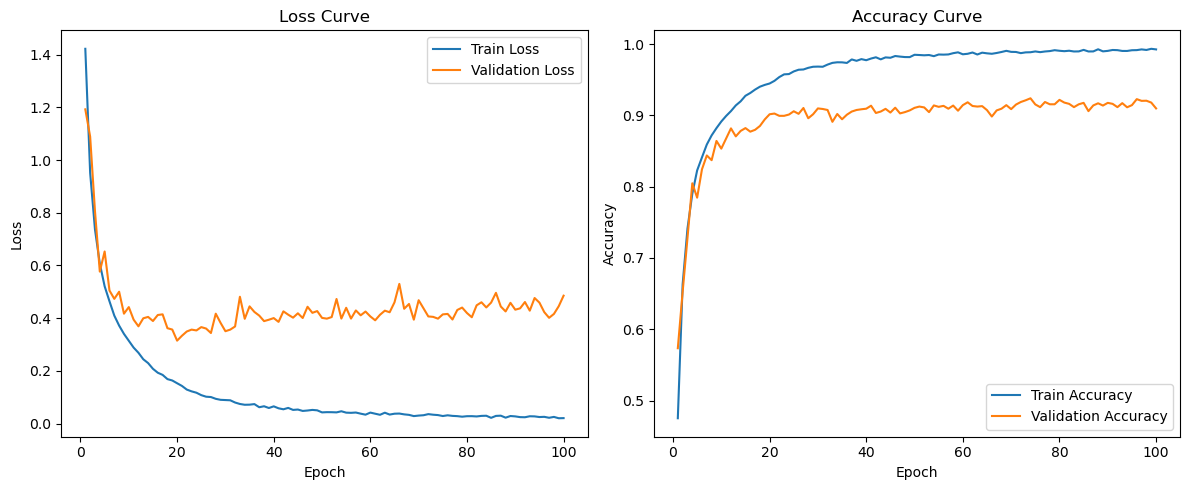

In [15]:
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, dev_losses, label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss Curve")

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, dev_accuracies, label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy Curve")

plt.tight_layout()
plt.savefig("training_curve.png")
plt.show()


In [16]:
model.eval()  # 设置为评估模式
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 90.83%


In [17]:
model2 = ResNetSmall(num_classes=10)
model2.load_state_dict(torch.load('best_model_adamW.pth'))
model2.to(device)
model2.eval()
test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model2(images)
        _, predicted = torch.max(outputs.data, 1)
        test_total += labels.size(0)
        test_correct += (predicted == labels).sum().item()

test_accuracy = 100 * test_correct / test_total
print(f"Test Accuracy: {test_accuracy:.2f}%")

Test Accuracy: 91.61%
